In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

In [3]:
def normalize(input_image, input_mask):
   
    # Normalize the pixel range values between [0:1]
    img = tf.cast(input_image, dtype=tf.float32) / 255.0
    input_mask -= 1
    return img, input_mask
 
@tf.function
def load_train_ds(dataset):
    img = tf.image.resize(dataset['image'], 
                          size=(width, height))
    mask = tf.image.resize(dataset['segmentation_mask'],
                           size=(width, height))
 
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
 
    img, mask = normalize(img, mask)
    return img, mask
 
@tf.function
def load_test_ds(dataset):
    img = tf.image.resize(dataset['image'], 
                          size=(width, height))
    mask = tf.image.resize(dataset['segmentation_mask'], 
                           size=(width, height))
 
    img, mask = normalize(img, mask)
    return img, mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
 
# Batch size is the number of examples used in one training example.
# It is mostly a power of 2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
 
# For VGG16 this is the input size
width, height = 224, 224

In [5]:
train = dataset['train'].map(
    load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)
 
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

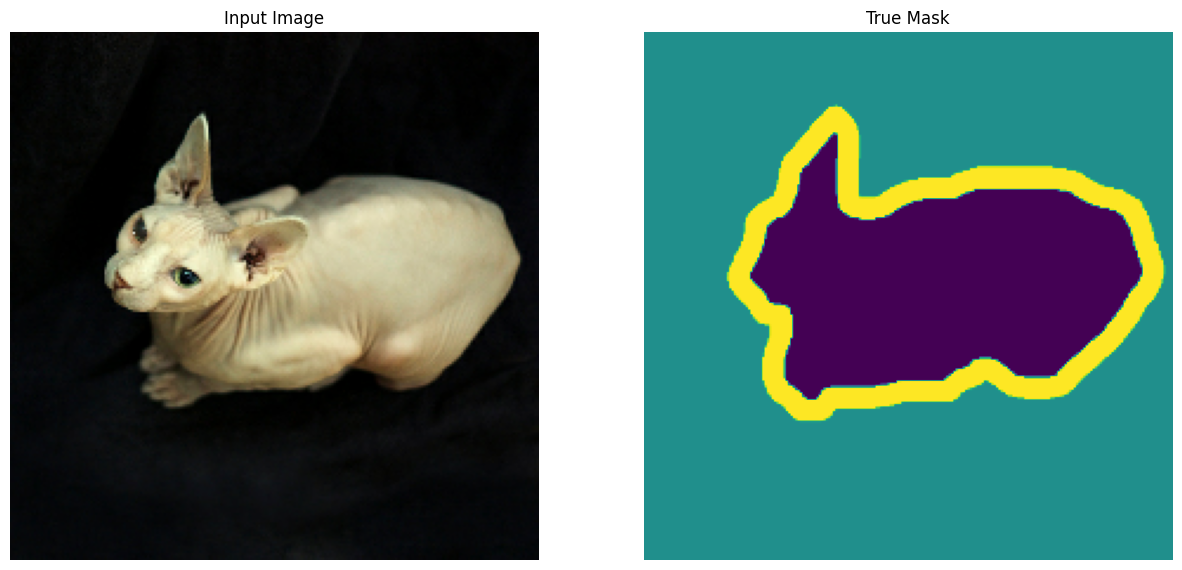

In [6]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 
             'Predicted Mask']
 
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
 
    plt.show()
 
 
for img, mask in train.take(1):
    sample_image, sample_mask = img, mask
    display_list = sample_image, sample_mask
 
display_images(display_list)

In [7]:
base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))
 
layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False
 
VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

58889256/58889256 [==============================] - 3s 0us/step


In [8]:
def fcn8_decoder(convs, n_classes):
    f1, f2, f3, f4, p5 = convs
 
    n = 4096
    c6 = tf.keras.layers.Conv2D(
        n, (7, 7), activation='relu', padding='same', 
      name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D(
        n, (1, 1), activation='relu', padding='same', 
      name="conv7")(c6)
 
    f5 = c7
 
    # upsample the output of the encoder
    # then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
        4, 4),  strides=(2, 2), use_bias=False)(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)
 
    # load the pool 4 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
                                 activation='relu', 
                                 padding='same'))(o2)
 
    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])
 
    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose(
        n_classes, kernel_size=(4, 4),  strides=(2, 2), 
      use_bias=False))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)
 
    # load the pool 3 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
                                 activation='relu', 
                                 padding='same'))(o2)
 
    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])
 
    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(
        n_classes, kernel_size=(8, 8),  strides=(8, 8),
      use_bias=False)(o)
 
    # append a softmax to get the class probabilities
    o = tf.keras.layers.Activation('softmax')(o)
    return o

In [9]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])


1/1 [==============================] - 4s 4s/step


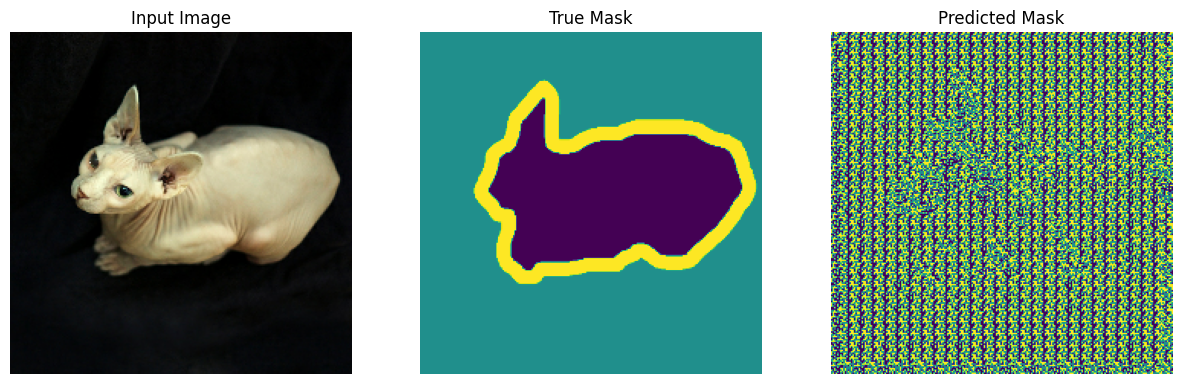

In [10]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


def show_predictions(dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions()


In [11]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)


Epoch 1/20


c:\Users\Admin\anaconda3\envs\venv_gpu\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 [==============================] - 26s 329ms/step - loss: 0.9249 - accuracy: 0.5213 - val_loss: 0.5765 - val_accuracy: 0.7592
Epoch 2/20
57/57 [==============================] - 22s 323ms/step - loss: 0.4798 - accuracy: 0.8060 - val_loss: 0.4649 - val_accuracy: 0.8089
Epoch 3/20
57/57 [==============================] - 18s 321ms/step - loss: 0.4045 - accuracy: 0.8289 - val_loss: 0.4163 - val_accuracy: 0.8210
Epoch 4/20
57/57 [==============================] - 18s 322ms/step - loss: 0.3701 - accuracy: 0.8384 - val_loss: 0.4150 - val_accuracy: 0.8219
Epoch 5/20
57/57 [==============================] - 18s 323ms/step - loss: 0.3403 - accuracy: 0.8465 - val_loss: 0.4053 - val_accuracy: 0.8268
Epoch 6/20
57/57 [==============================] - 18s 322ms/step - loss: 0.3228 - accuracy: 0.8513 - val_loss: 0.4132 - val_accuracy: 0.8267
Epoch 7/20
57/57 [==============================] - 18s 322ms/step - loss: 0.3003 - accuracy: 0.8568 - val_loss: 0.4035 - val_accuracy: 0.8284
Epoch 8/20

In [12]:
def compute_metrics(y_true, y_pred):
	'''
	Computes IOU and Dice Score.

	Args:
	y_true (tensor) - ground truth label map
	y_pred (tensor) - predicted label map
	'''

	class_wise_iou = []
	class_wise_dice_score = []

	smoothening_factor = 0.00001

	for i in range(3):
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))
		y_pred_area = np.sum((y_pred == i))
		combined_area = y_true_area + y_pred_area

		iou = (intersection + smoothening_factor) / \
			(combined_area - intersection + smoothening_factor)
		class_wise_iou.append(iou)

		dice_score = 2 * ((intersection + smoothening_factor) /
						(combined_area + smoothening_factor))
		class_wise_dice_score.append(dice_score)

	return class_wise_iou, class_wise_dice_score


In [17]:
def get_test_image_and_annotation_arrays():
	'''
	Unpacks the test dataset and returns
	the input images and segmentation masks
	'''

	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	images = []
	y_true_segments = []

	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	y_true_segments = y_true_segments[:(
		info.splits['test'].num_examples - (info.splits['test']
											.num_examples % BATCH_SIZE))]
	images = images[:(info.splits['test'].num_examples -
					(info.splits['test'].num_examples % BATCH_SIZE))]

	return images, y_true_segments


y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape


def display_prediction(display_list, display_string):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
		plt.xticks([])
		plt.yticks([])
		if i == 1:
			plt.xlabel(display_string, fontsize=12)
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
	plt.show()


iou, dice_score = compute_metrics(
	y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider],
				y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx],
														i, dc) for idx, (i, dc) in
					enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)


1/1 [==============================] - 0s 16ms/step


NameError: name 'display_string' is not defined